# Dataset Visualization

* Token distribution
* Embedding clustering

In [1]:
import os
import json
import tiktoken
import numpy as np
import matplotlib.pyplot as plt

In [7]:
os.chdir("../")
from modules.chromadb_handler import ChromaDBHandler
from utils.token_count import num_tokens_from_string
from utils.jsons import load_json

## 1. Load Encoding

In [3]:
encoding = tiktoken.get_encoding("cl100k_base")

Use tiktoken.encoding_for_model() to automatically load the correct encoding for a given model name.

In [4]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

## 2. Turn text into tokens with encoding.encode()

The .encode() method converts a text string into a list of token integers.

In [5]:
encoding.encode("tiktoken is great!")

[83, 1609, 5963, 374, 2294, 0]

Count tokens by counting the length of the list returned by .encode().

In [6]:
num_tokens_from_string("tiktoken is great!", "cl100k_base")

6

## 3. Loading Golden Dataset

In [8]:
trials = ChromaDBHandler("data/collections/", 'ctrials').collection
trials.count()

No embedding_function provided, using default embedding function: DefaultEmbeddingFunction https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2


16508

In [9]:
dataset = load_json("data/interim/random_t_annotation_500_42.json")

In [10]:
# Selecting the ids only
dataset_ids = list(dataset.keys())
len(dataset_ids)

166

In [11]:
# Get the documents for the dataset ids
dataset_data = trials.get(ids=dataset_ids, include = ['documents', 'embeddings'])
dataset_docs = dataset_data['documents']

In [12]:
dataset_docs[0]

'This is an open-label, multicenter, dose-escalation and parallel-group expansion Phase II\n clinical trial to evaluate the efficacy, safety and tolerability of KN026 in combination with\n palbociclib and fulvestrant in women or male with HER2-positive metastatic breast cancer .The\n subjects will receive 20 mg/kg IV Q2W+ palbociclib 100/125 mg/day orally+/-Fulvestrant 500 mg\n IM until progressive disease, unacceptable toxicity or death.\n ;\n ;\n Inclusion Criteria:\n - Male or female subject >= 18 years;\n - Histologically or cytologically confirmed, metastatic or locally advanced unresectable\n HER2-positive;\n - Adequate organ function assessed within 7 days prior to first trial treatment\n - ECOG score 0 or 1;\n - Left ventricular ejection fraction (LVEF) ≥ 50% at baseline;\n - Life expectancy >3 months\n Exclusion Criteria:\n - Untreated active CNS metastasis or leptomeningeal metastasis;\n - Uncontrolled tumor-related pain;\n - Has received other anti-tumor treatment or an inve

## 4. Counting tokens for our Golden dataset

In [13]:
tokens = [num_tokens_from_string(doc, "cl100k_base") for doc in dataset_docs]

In [14]:
len(tokens)

166

In [20]:
import numpy as np

# Your code for generating the tokens list
tokens = [num_tokens_from_string(doc, "cl100k_base") for doc in dataset_docs]

# Find the index of the document with the longest token length
longest_token_index = np.argmax(tokens)

print(f"The document with the longest token length is at index: {longest_token_index}")


The document with the longest token length is at index: 32


In [26]:
dataset_data['ids'][32]

'NCT04017130'

## 5. Visualize token distribution

In [15]:
if not os.path.exists("images"):
    os.mkdir("images")

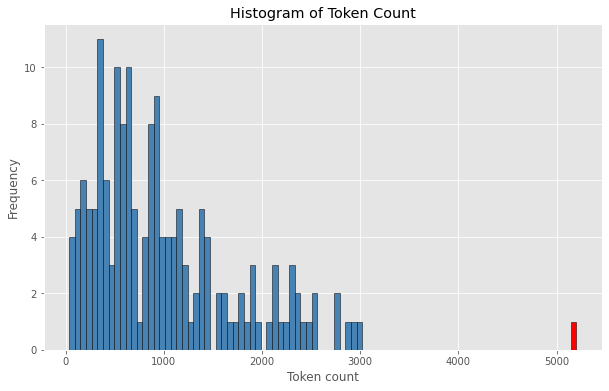

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6)) # Make it 14x7 inch
#plt.hist(tokens, bins=90, ,  ec="black", color = "steelblue")
n, bins, patches = plt.hist(tokens, bins=90,linewidth=0.5, ec="black" ,color='steelblue')
patches[89].set_fc('r') # the last is 
plt.title('Histogram of Token Count') 
plt.xlabel('Token count') 
plt.ylabel('Frequency') 
plt.savefig('images/token_count_hist_redbar.png')
plt.show()

In [17]:
short_docs = [i for i in dataset_docs if num_tokens_from_string(i, "cl100k_base") > 5000]

In [18]:
short_docs

["This will be a Phase 1 Open-Label, dose escalation and expansion study of MT-0169 (an\n Engineered toxin body (ETB) in patients with relapsed or refractory multiple myeloma or\n non-Hodgkin lymphoma. MT-0169 is an investigational drug that recognizes and binds to the\n CD38 receptor, which may be found on the surface of multiple myeloma and non-Hodgkin lymphoma\n cancer cells. It delivers a dose of a modified toxin that kills these cells.\n ;\n ;\n Inclusion Criteria Part 1 (RRMM patients only)\n 1. Confirmed diagnosis of MM per revised IMWG diagnostic criteria\n 2. Patients with RRMM who have failed treatment with, are intolerant to, or are not\n candidates for available therapies that are known to confer clinical benefit\n 3. Must meet all of the following criteria for prior therapy:\n 1. Must be refractory to ≥1 proteasome inhibitor (PI), ≥1 immunomodulatory drug\n (IMiD), and ≥1 steroid\n 2. Must either have received ≥3 prior lines of therapy or ≥2 prior lines of therapy\n if 1 l

## Visualize Embeddings

In [12]:
from umap import UMAP
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'

In [13]:
# Load embeddings
dataset_embs = np.array(dataset_data['embeddings'])

In [34]:
# Reduce dimensionality of embeddings
umap_fit = UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric='cosine').fit(dataset_embs)
projections = umap_fit.transform(dataset_embs)

In [35]:
import pylab as plt

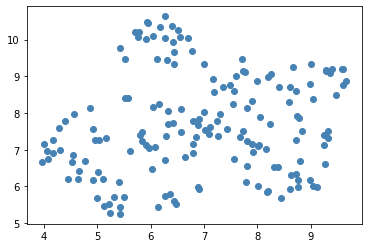

In [36]:
plt.scatter(projections[:, 0],projections[:, 1],color='steelblue')
plt.savefig("images/umap_10neig_2cmp.jpeg")
#plt.scatter(X,Y2,color='g')
plt.show()

In [39]:
# train/test

In [53]:
train_set = load_json("data/processed/train_set.json")
# Selecting the ids only
train_ids = [i['trial_id'] for i in train_set['ids']]
# Get the documents for the dataset ids
train_data = trials.get(ids=train_ids, include = ['documents', 'embeddings'])
train_embeddings = train_data['embeddings']

In [56]:
test_set = load_json("data/processed/test_set.json")
# Selecting the ids only
test_ids = [i['trial_id'] for i in test_set['ids']]
# Get the documents for the dataset ids
test_data = trials.get(ids=test_ids, include = ['documents', 'embeddings'])
test_embeddings = test_data['embeddings']

In [58]:
train_em = umap_fit.transform(train_embeddings)
test_em = umap_fit.transform(test_embeddings)

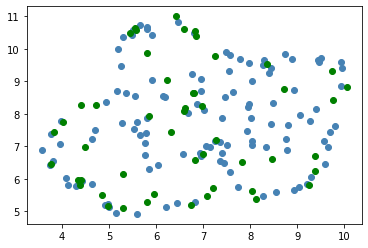

In [60]:
plt.scatter(train_em[:, 0],train_em[:, 1],color='steelblue')
plt.scatter(test_em[:, 0],test_em[:, 1],color='green')
plt.savefig("images/umap_10neig_2cmp_train_test.jpeg")